<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[15:13:59] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


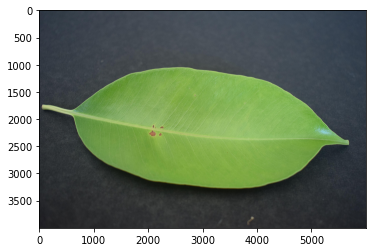

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

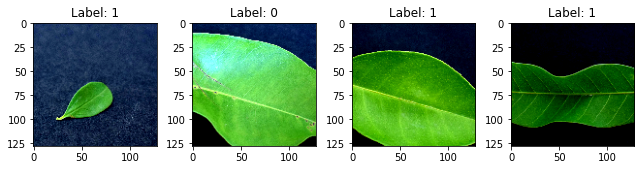

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[15:14:05] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[15:14:07] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2616883273636348 samples/sec                   batch loss = 1.9541743993759155 | accuracy = 0.5


Epoch[1] Batch[10] Speed: 1.271019892262053 samples/sec                   batch loss = 1.0228595733642578 | accuracy = 0.5


Epoch[1] Batch[15] Speed: 1.2619658236344042 samples/sec                   batch loss = 1.5686932802200317 | accuracy = 0.5666666666666667


Epoch[1] Batch[20] Speed: 1.2698554561755264 samples/sec                   batch loss = 0.36451274156570435 | accuracy = 0.575


Epoch[1] Batch[25] Speed: 1.2726358743370747 samples/sec                   batch loss = 0.35332557559013367 | accuracy = 0.63


Epoch[1] Batch[30] Speed: 1.267819178078051 samples/sec                   batch loss = 0.6097509264945984 | accuracy = 0.6166666666666667


Epoch[1] Batch[35] Speed: 1.2800632843786832 samples/sec                   batch loss = 0.48519474267959595 | accuracy = 0.6357142857142857


Epoch[1] Batch[40] Speed: 1.2696842033248543 samples/sec                   batch loss = 0.5531649589538574 | accuracy = 0.65625


Epoch[1] Batch[45] Speed: 1.2742158076219408 samples/sec                   batch loss = 1.2564257383346558 | accuracy = 0.6388888888888888


Epoch[1] Batch[50] Speed: 1.275475910145677 samples/sec                   batch loss = 0.35689735412597656 | accuracy = 0.64


Epoch[1] Batch[55] Speed: 1.274523918989425 samples/sec                   batch loss = 0.7520411610603333 | accuracy = 0.6318181818181818


Epoch[1] Batch[60] Speed: 1.270000990129289 samples/sec                   batch loss = 0.5602229237556458 | accuracy = 0.625


Epoch[1] Batch[65] Speed: 1.269677957601309 samples/sec                   batch loss = 0.5870782732963562 | accuracy = 0.6307692307692307


Epoch[1] Batch[70] Speed: 1.2739185821833956 samples/sec                   batch loss = 0.9817568063735962 | accuracy = 0.6178571428571429


Epoch[1] Batch[75] Speed: 1.2731210551265626 samples/sec                   batch loss = 0.65207839012146 | accuracy = 0.6266666666666667


Epoch[1] Batch[80] Speed: 1.2686454720329545 samples/sec                   batch loss = 1.2454910278320312 | accuracy = 0.625


Epoch[1] Batch[85] Speed: 1.2698769861772374 samples/sec                   batch loss = 1.021761417388916 | accuracy = 0.6205882352941177


Epoch[1] Batch[90] Speed: 1.2752792910824562 samples/sec                   batch loss = 0.4611092805862427 | accuracy = 0.6194444444444445


Epoch[1] Batch[95] Speed: 1.2710324101894623 samples/sec                   batch loss = 0.5915033221244812 | accuracy = 0.6157894736842106


Epoch[1] Batch[100] Speed: 1.2736807662787546 samples/sec                   batch loss = 1.38905930519104 | accuracy = 0.6175


Epoch[1] Batch[105] Speed: 1.2764550597663455 samples/sec                   batch loss = 0.7559810280799866 | accuracy = 0.6190476190476191


Epoch[1] Batch[110] Speed: 1.2730123787990513 samples/sec                   batch loss = 0.470777690410614 | accuracy = 0.625


Epoch[1] Batch[115] Speed: 1.2778068890551617 samples/sec                   batch loss = 0.8029772043228149 | accuracy = 0.6217391304347826


Epoch[1] Batch[120] Speed: 1.2732257883603755 samples/sec                   batch loss = 0.5914657711982727 | accuracy = 0.6208333333333333


Epoch[1] Batch[125] Speed: 1.2754451723003362 samples/sec                   batch loss = 0.7361483573913574 | accuracy = 0.626


Epoch[1] Batch[130] Speed: 1.2664926900375104 samples/sec                   batch loss = 0.30853497982025146 | accuracy = 0.6307692307692307


Epoch[1] Batch[135] Speed: 1.2712887930557624 samples/sec                   batch loss = 0.7250223159790039 | accuracy = 0.6277777777777778


Epoch[1] Batch[140] Speed: 1.2773319401658736 samples/sec                   batch loss = 0.6384168863296509 | accuracy = 0.6285714285714286


Epoch[1] Batch[145] Speed: 1.269049183740404 samples/sec                   batch loss = 0.40800368785858154 | accuracy = 0.6327586206896552


Epoch[1] Batch[150] Speed: 1.2668660461768504 samples/sec                   batch loss = 0.37028294801712036 | accuracy = 0.63


Epoch[1] Batch[155] Speed: 1.2709748297648973 samples/sec                   batch loss = 1.7015013694763184 | accuracy = 0.6258064516129033


Epoch[1] Batch[160] Speed: 1.2697076493584414 samples/sec                   batch loss = 0.8669086694717407 | accuracy = 0.61875


Epoch[1] Batch[165] Speed: 1.271724264439744 samples/sec                   batch loss = 0.7268742918968201 | accuracy = 0.6196969696969697


Epoch[1] Batch[170] Speed: 1.2763260055397785 samples/sec                   batch loss = 0.30572935938835144 | accuracy = 0.6279411764705882


Epoch[1] Batch[175] Speed: 1.267606906536482 samples/sec                   batch loss = 0.6259217262268066 | accuracy = 0.6271428571428571


Epoch[1] Batch[180] Speed: 1.2652106687778126 samples/sec                   batch loss = 0.437608540058136 | accuracy = 0.6263888888888889


Epoch[1] Batch[185] Speed: 1.2673331467521465 samples/sec                   batch loss = 0.871202826499939 | accuracy = 0.6270270270270271


Epoch[1] Batch[190] Speed: 1.2731313924191643 samples/sec                   batch loss = 0.6710469126701355 | accuracy = 0.6263157894736842


Epoch[1] Batch[195] Speed: 1.2704039297887675 samples/sec                   batch loss = 0.6259878873825073 | accuracy = 0.6294871794871795


Epoch[1] Batch[200] Speed: 1.2723755705215527 samples/sec                   batch loss = 0.31381064653396606 | accuracy = 0.63375


Epoch[1] Batch[205] Speed: 1.2721959197440262 samples/sec                   batch loss = 1.550779938697815 | accuracy = 0.6378048780487805


Epoch[1] Batch[210] Speed: 1.268923734029083 samples/sec                   batch loss = 0.4282684028148651 | accuracy = 0.6392857142857142


Epoch[1] Batch[215] Speed: 1.2685199102966773 samples/sec                   batch loss = 0.7147467136383057 | accuracy = 0.6406976744186047


Epoch[1] Batch[220] Speed: 1.2779589239415137 samples/sec                   batch loss = 0.466081440448761 | accuracy = 0.6431818181818182


Epoch[1] Batch[225] Speed: 1.2753284401650085 samples/sec                   batch loss = 0.5210881233215332 | accuracy = 0.6466666666666666


Epoch[1] Batch[230] Speed: 1.2738248572213862 samples/sec                   batch loss = 0.7779698371887207 | accuracy = 0.6434782608695652


Epoch[1] Batch[235] Speed: 1.2735700608234413 samples/sec                   batch loss = 0.7422289848327637 | accuracy = 0.6446808510638298


Epoch[1] Batch[240] Speed: 1.2677762582424799 samples/sec                   batch loss = 1.0997565984725952 | accuracy = 0.64375


Epoch[1] Batch[245] Speed: 1.2700834805880417 samples/sec                   batch loss = 0.230708509683609 | accuracy = 0.6469387755102041


Epoch[1] Batch[250] Speed: 1.270295909187997 samples/sec                   batch loss = 0.4236522614955902 | accuracy = 0.651


Epoch[1] Batch[255] Speed: 1.2701809831287736 samples/sec                   batch loss = 0.43587931990623474 | accuracy = 0.6519607843137255


Epoch[1] Batch[260] Speed: 1.2718053399520637 samples/sec                   batch loss = 0.2861713469028473 | accuracy = 0.6528846153846154


Epoch[1] Batch[265] Speed: 1.2644466845160598 samples/sec                   batch loss = 0.5124951004981995 | accuracy = 0.6509433962264151


Epoch[1] Batch[270] Speed: 1.2698600696858626 samples/sec                   batch loss = 0.6911067366600037 | accuracy = 0.6509259259259259


Epoch[1] Batch[275] Speed: 1.2661841488192873 samples/sec                   batch loss = 0.8776615858078003 | accuracy = 0.6527272727272727


Epoch[1] Batch[280] Speed: 1.2710824843649093 samples/sec                   batch loss = 0.6202863454818726 | accuracy = 0.6517857142857143


Epoch[1] Batch[285] Speed: 1.2741598737537 samples/sec                   batch loss = 1.0304421186447144 | accuracy = 0.6526315789473685


Epoch[1] Batch[290] Speed: 1.2696744023707347 samples/sec                   batch loss = 0.6488407254219055 | accuracy = 0.6551724137931034


Epoch[1] Batch[295] Speed: 1.2757260374636001 samples/sec                   batch loss = 0.3433759808540344 | accuracy = 0.6542372881355932


Epoch[1] Batch[300] Speed: 1.2700638665009505 samples/sec                   batch loss = 0.6302630305290222 | accuracy = 0.6566666666666666


Epoch[1] Batch[305] Speed: 1.2848371562432848 samples/sec                   batch loss = 0.5507046580314636 | accuracy = 0.659016393442623


Epoch[1] Batch[310] Speed: 1.2743154943360644 samples/sec                   batch loss = 0.31664255261421204 | accuracy = 0.6629032258064517


Epoch[1] Batch[315] Speed: 1.274786652455781 samples/sec                   batch loss = 0.6875861883163452 | accuracy = 0.6611111111111111


Epoch[1] Batch[320] Speed: 1.272778473699032 samples/sec                   batch loss = 0.6619356274604797 | accuracy = 0.66171875


Epoch[1] Batch[325] Speed: 1.2711181164691965 samples/sec                   batch loss = 0.47378605604171753 | accuracy = 0.6630769230769231


Epoch[1] Batch[330] Speed: 1.2739526322307764 samples/sec                   batch loss = 0.4205509126186371 | accuracy = 0.6636363636363637


Epoch[1] Batch[335] Speed: 1.2692285229508242 samples/sec                   batch loss = 0.4281270503997803 | accuracy = 0.6649253731343283


Epoch[1] Batch[340] Speed: 1.2708799971275466 samples/sec                   batch loss = 1.7430617809295654 | accuracy = 0.6647058823529411


Epoch[1] Batch[345] Speed: 1.275410654593411 samples/sec                   batch loss = 0.20912949740886688 | accuracy = 0.6681159420289855


Epoch[1] Batch[350] Speed: 1.2775292900106445 samples/sec                   batch loss = 0.5081309080123901 | accuracy = 0.6685714285714286


Epoch[1] Batch[355] Speed: 1.282678934924588 samples/sec                   batch loss = 0.5420743823051453 | accuracy = 0.6690140845070423


Epoch[1] Batch[360] Speed: 1.2751248887310722 samples/sec                   batch loss = 0.3289487659931183 | accuracy = 0.6694444444444444


Epoch[1] Batch[365] Speed: 1.2733975147170888 samples/sec                   batch loss = 0.5410912036895752 | accuracy = 0.6684931506849315


Epoch[1] Batch[370] Speed: 1.2443529229308439 samples/sec                   batch loss = 1.0634491443634033 | accuracy = 0.6668918918918919


Epoch[1] Batch[375] Speed: 1.2720591413070659 samples/sec                   batch loss = 0.5015028715133667 | accuracy = 0.668


Epoch[1] Batch[380] Speed: 1.2702633046197103 samples/sec                   batch loss = 0.7093843817710876 | accuracy = 0.6697368421052632


Epoch[1] Batch[385] Speed: 1.2752191928164818 samples/sec                   batch loss = 0.3165327310562134 | accuracy = 0.6701298701298701


Epoch[1] Batch[390] Speed: 1.2750849615024604 samples/sec                   batch loss = 1.0453319549560547 | accuracy = 0.6724358974358975


Epoch[1] Batch[395] Speed: 1.2771154993254068 samples/sec                   batch loss = 0.436258465051651 | accuracy = 0.6740506329113924


Epoch[1] Batch[400] Speed: 1.275257771374925 samples/sec                   batch loss = 0.3298688530921936 | accuracy = 0.676875


Epoch[1] Batch[405] Speed: 1.2786229673913805 samples/sec                   batch loss = 0.6847935318946838 | accuracy = 0.6777777777777778


Epoch[1] Batch[410] Speed: 1.2747712515240148 samples/sec                   batch loss = 0.5525528192520142 | accuracy = 0.6786585365853659


Epoch[1] Batch[415] Speed: 1.272273582087662 samples/sec                   batch loss = 0.36207395792007446 | accuracy = 0.677710843373494


Epoch[1] Batch[420] Speed: 1.2726266069671863 samples/sec                   batch loss = 0.4075135886669159 | accuracy = 0.6797619047619048


Epoch[1] Batch[425] Speed: 1.273338076887318 samples/sec                   batch loss = 0.6852750778198242 | accuracy = 0.6823529411764706


Epoch[1] Batch[430] Speed: 1.272244927920446 samples/sec                   batch loss = 0.5358141660690308 | accuracy = 0.6831395348837209


Epoch[1] Batch[435] Speed: 1.2750255598408826 samples/sec                   batch loss = 0.8900929689407349 | accuracy = 0.6827586206896552


Epoch[1] Batch[440] Speed: 1.2761069935421923 samples/sec                   batch loss = 0.42561155557632446 | accuracy = 0.6835227272727272


Epoch[1] Batch[445] Speed: 1.2720288572525562 samples/sec                   batch loss = 0.2804187536239624 | accuracy = 0.6859550561797753


Epoch[1] Batch[450] Speed: 1.2762815369162173 samples/sec                   batch loss = 0.8846499919891357 | accuracy = 0.6866666666666666


Epoch[1] Batch[455] Speed: 1.2751054093581362 samples/sec                   batch loss = 0.38839268684387207 | accuracy = 0.6857142857142857


Epoch[1] Batch[460] Speed: 1.2702889841839435 samples/sec                   batch loss = 0.5255222320556641 | accuracy = 0.6875


Epoch[1] Batch[465] Speed: 1.2720526793018077 samples/sec                   batch loss = 0.8352015614509583 | accuracy = 0.6876344086021505


Epoch[1] Batch[470] Speed: 1.2736960441758898 samples/sec                   batch loss = 0.6141752600669861 | accuracy = 0.6872340425531915


Epoch[1] Batch[475] Speed: 1.2694737082645178 samples/sec                   batch loss = 0.5826714038848877 | accuracy = 0.6894736842105263


Epoch[1] Batch[480] Speed: 1.2713346485267576 samples/sec                   batch loss = 0.968675434589386 | accuracy = 0.6895833333333333


Epoch[1] Batch[485] Speed: 1.269217768850255 samples/sec                   batch loss = 0.8015705347061157 | accuracy = 0.6907216494845361


Epoch[1] Batch[490] Speed: 1.2711432527498339 samples/sec                   batch loss = 0.379406213760376 | accuracy = 0.6908163265306122


Epoch[1] Batch[495] Speed: 1.2760813693910227 samples/sec                   batch loss = 0.3707432150840759 | accuracy = 0.6904040404040404


Epoch[1] Batch[500] Speed: 1.2738721532338297 samples/sec                   batch loss = 0.6322044730186462 | accuracy = 0.69


Epoch[1] Batch[505] Speed: 1.2704705019433549 samples/sec                   batch loss = 0.5802276134490967 | accuracy = 0.689108910891089


Epoch[1] Batch[510] Speed: 1.2698334463480894 samples/sec                   batch loss = 0.5046838521957397 | accuracy = 0.6897058823529412


Epoch[1] Batch[515] Speed: 1.2724883847205366 samples/sec                   batch loss = 0.4772474467754364 | accuracy = 0.6902912621359223


Epoch[1] Batch[520] Speed: 1.2715644573774458 samples/sec                   batch loss = 0.12832804024219513 | accuracy = 0.6913461538461538


Epoch[1] Batch[525] Speed: 1.2710897069273233 samples/sec                   batch loss = 0.5210398435592651 | accuracy = 0.690952380952381


Epoch[1] Batch[530] Speed: 1.2727362794961767 samples/sec                   batch loss = 0.49697431921958923 | accuracy = 0.6929245283018868


Epoch[1] Batch[535] Speed: 1.2710149814501779 samples/sec                   batch loss = 0.3769453465938568 | accuracy = 0.6929906542056075


Epoch[1] Batch[540] Speed: 1.2737151904125412 samples/sec                   batch loss = 0.3229348957538605 | accuracy = 0.6935185185185185


Epoch[1] Batch[545] Speed: 1.2779965002375122 samples/sec                   batch loss = 0.6141388416290283 | accuracy = 0.6931192660550459


Epoch[1] Batch[550] Speed: 1.2725792103420361 samples/sec                   batch loss = 0.4762989282608032 | accuracy = 0.6931818181818182


Epoch[1] Batch[555] Speed: 1.2717300483193588 samples/sec                   batch loss = 0.180073082447052 | accuracy = 0.6936936936936937


Epoch[1] Batch[560] Speed: 1.2620230653052609 samples/sec                   batch loss = 0.5081809759140015 | accuracy = 0.6941964285714286


Epoch[1] Batch[565] Speed: 1.273748359245406 samples/sec                   batch loss = 0.8202797770500183 | accuracy = 0.695575221238938


Epoch[1] Batch[570] Speed: 1.2647363597259815 samples/sec                   batch loss = 0.9749811291694641 | accuracy = 0.6951754385964912


Epoch[1] Batch[575] Speed: 1.268508592736485 samples/sec                   batch loss = 0.7024825811386108 | accuracy = 0.6956521739130435


Epoch[1] Batch[580] Speed: 1.2726228421367227 samples/sec                   batch loss = 1.0181100368499756 | accuracy = 0.6961206896551724


Epoch[1] Batch[585] Speed: 1.2705818238631386 samples/sec                   batch loss = 0.3980156183242798 | accuracy = 0.6965811965811965


Epoch[1] Batch[590] Speed: 1.270967704790813 samples/sec                   batch loss = 0.8977335691452026 | accuracy = 0.6949152542372882


Epoch[1] Batch[595] Speed: 1.2731970912863808 samples/sec                   batch loss = 0.2250710129737854 | accuracy = 0.6953781512605042


Epoch[1] Batch[600] Speed: 1.2733411694505576 samples/sec                   batch loss = 0.49291104078292847 | accuracy = 0.6958333333333333


Epoch[1] Batch[605] Speed: 1.2776797993024447 samples/sec                   batch loss = 0.37663552165031433 | accuracy = 0.6958677685950413


Epoch[1] Batch[610] Speed: 1.2750919388960889 samples/sec                   batch loss = 1.2372024059295654 | accuracy = 0.6950819672131148


Epoch[1] Batch[615] Speed: 1.2830861338390664 samples/sec                   batch loss = 0.4244348406791687 | accuracy = 0.6951219512195121


Epoch[1] Batch[620] Speed: 1.2757344769704262 samples/sec                   batch loss = 0.34751951694488525 | accuracy = 0.6955645161290323


Epoch[1] Batch[625] Speed: 1.2740052586116886 samples/sec                   batch loss = 0.38248133659362793 | accuracy = 0.6968


Epoch[1] Batch[630] Speed: 1.2711790808910914 samples/sec                   batch loss = 0.30199334025382996 | accuracy = 0.6964285714285714


Epoch[1] Batch[635] Speed: 1.265459744725427 samples/sec                   batch loss = 0.21328695118427277 | accuracy = 0.6968503937007874


Epoch[1] Batch[640] Speed: 1.2695906199975089 samples/sec                   batch loss = 0.4163842797279358 | accuracy = 0.69765625


Epoch[1] Batch[645] Speed: 1.265085309024986 samples/sec                   batch loss = 0.7143152952194214 | accuracy = 0.6972868217054263


Epoch[1] Batch[650] Speed: 1.2662064145732994 samples/sec                   batch loss = 0.4335212707519531 | accuracy = 0.6976923076923077


Epoch[1] Batch[655] Speed: 1.2693934099680866 samples/sec                   batch loss = 0.4278497099876404 | accuracy = 0.6988549618320611


Epoch[1] Batch[660] Speed: 1.2723388064861825 samples/sec                   batch loss = 0.3615093529224396 | accuracy = 0.6988636363636364


Epoch[1] Batch[665] Speed: 1.2647683951436293 samples/sec                   batch loss = 0.626929521560669 | accuracy = 0.6996240601503759


Epoch[1] Batch[670] Speed: 1.2548555936130266 samples/sec                   batch loss = 0.1709921956062317 | accuracy = 0.7


Epoch[1] Batch[675] Speed: 1.2628957177870517 samples/sec                   batch loss = 0.1784525066614151 | accuracy = 0.7003703703703704


Epoch[1] Batch[680] Speed: 1.2637748136997542 samples/sec                   batch loss = 0.45864787697792053 | accuracy = 0.7003676470588235


Epoch[1] Batch[685] Speed: 1.2676762509726383 samples/sec                   batch loss = 0.4632580280303955 | accuracy = 0.7007299270072993


Epoch[1] Batch[690] Speed: 1.2614472780172352 samples/sec                   batch loss = 0.34285968542099 | accuracy = 0.7018115942028985


Epoch[1] Batch[695] Speed: 1.2718556678835449 samples/sec                   batch loss = 0.5663965344429016 | accuracy = 0.702158273381295


Epoch[1] Batch[700] Speed: 1.271571685418261 samples/sec                   batch loss = 0.6430851817131042 | accuracy = 0.7017857142857142


Epoch[1] Batch[705] Speed: 1.2688588592881096 samples/sec                   batch loss = 0.46722978353500366 | accuracy = 0.701418439716312


Epoch[1] Batch[710] Speed: 1.263677911424979 samples/sec                   batch loss = 0.5178222060203552 | accuracy = 0.701056338028169


Epoch[1] Batch[715] Speed: 1.2681123177645834 samples/sec                   batch loss = 0.311593621969223 | accuracy = 0.7006993006993008


Epoch[1] Batch[720] Speed: 1.2666121132822996 samples/sec                   batch loss = 0.6167248487472534 | accuracy = 0.7010416666666667


Epoch[1] Batch[725] Speed: 1.265747878973518 samples/sec                   batch loss = 0.6997765302658081 | accuracy = 0.7010344827586207


Epoch[1] Batch[730] Speed: 1.2662625124552829 samples/sec                   batch loss = 0.2672862410545349 | accuracy = 0.7013698630136986


Epoch[1] Batch[735] Speed: 1.2693373224477036 samples/sec                   batch loss = 0.8275722861289978 | accuracy = 0.7013605442176871


Epoch[1] Batch[740] Speed: 1.2700084888191185 samples/sec                   batch loss = 0.3660952150821686 | accuracy = 0.7016891891891892


Epoch[1] Batch[745] Speed: 1.2676110248477122 samples/sec                   batch loss = 1.0068413019180298 | accuracy = 0.7023489932885906


Epoch[1] Batch[750] Speed: 1.2697441653974686 samples/sec                   batch loss = 0.5028171539306641 | accuracy = 0.7023333333333334


Epoch[1] Batch[755] Speed: 1.2750520137308954 samples/sec                   batch loss = 0.6171452403068542 | accuracy = 0.7039735099337748


Epoch[1] Batch[760] Speed: 1.2611603397729836 samples/sec                   batch loss = 0.36080414056777954 | accuracy = 0.7036184210526316


Epoch[1] Batch[765] Speed: 1.264692790348868 samples/sec                   batch loss = 0.559943675994873 | accuracy = 0.7052287581699347


Epoch[1] Batch[770] Speed: 1.2650231153852562 samples/sec                   batch loss = 0.618595540523529 | accuracy = 0.7035714285714286


Epoch[1] Batch[775] Speed: 1.2683898664386108 samples/sec                   batch loss = 0.4271015524864197 | accuracy = 0.7038709677419355


Epoch[1] Batch[780] Speed: 1.2708973258928304 samples/sec                   batch loss = 0.5676462054252625 | accuracy = 0.7048076923076924


Epoch[1] Batch[785] Speed: 1.2685048522313322 samples/sec                   batch loss = 0.42228013277053833 | accuracy = 0.7057324840764331


[Epoch 1] training: accuracy=0.7052664974619289
[Epoch 1] time cost: 646.2564268112183
[Epoch 1] validation: validation accuracy=0.7466666666666667


Epoch[2] Batch[5] Speed: 1.2635487632263467 samples/sec                   batch loss = 0.6894898414611816 | accuracy = 0.65


Epoch[2] Batch[10] Speed: 1.2685736235053224 samples/sec                   batch loss = 0.967473030090332 | accuracy = 0.65


Epoch[2] Batch[15] Speed: 1.2630635276563085 samples/sec                   batch loss = 0.4677068889141083 | accuracy = 0.6666666666666666


Epoch[2] Batch[20] Speed: 1.26265021577366 samples/sec                   batch loss = 0.3809928596019745 | accuracy = 0.725


Epoch[2] Batch[25] Speed: 1.2633458150222587 samples/sec                   batch loss = 0.3912578821182251 | accuracy = 0.72


Epoch[2] Batch[30] Speed: 1.261362965696286 samples/sec                   batch loss = 0.45651811361312866 | accuracy = 0.7166666666666667


Epoch[2] Batch[35] Speed: 1.2618892247465197 samples/sec                   batch loss = 0.3839910328388214 | accuracy = 0.7142857142857143


Epoch[2] Batch[40] Speed: 1.2599315679048337 samples/sec                   batch loss = 0.5964943766593933 | accuracy = 0.70625


Epoch[2] Batch[45] Speed: 1.2696387550783572 samples/sec                   batch loss = 0.2705296576023102 | accuracy = 0.7166666666666667


Epoch[2] Batch[50] Speed: 1.2643079466952265 samples/sec                   batch loss = 0.31691285967826843 | accuracy = 0.715


Epoch[2] Batch[55] Speed: 1.2659193133021303 samples/sec                   batch loss = 0.8228506445884705 | accuracy = 0.7090909090909091


Epoch[2] Batch[60] Speed: 1.2639161958337484 samples/sec                   batch loss = 0.22410139441490173 | accuracy = 0.7041666666666667


Epoch[2] Batch[65] Speed: 1.265246735774076 samples/sec                   batch loss = 0.3942508399486542 | accuracy = 0.7038461538461539


Epoch[2] Batch[70] Speed: 1.2639010564365198 samples/sec                   batch loss = 0.5241079926490784 | accuracy = 0.7035714285714286


Epoch[2] Batch[75] Speed: 1.2577091322136116 samples/sec                   batch loss = 0.7816018462181091 | accuracy = 0.69


Epoch[2] Batch[80] Speed: 1.264730925307206 samples/sec                   batch loss = 0.8616116046905518 | accuracy = 0.68125


Epoch[2] Batch[85] Speed: 1.2620545836657622 samples/sec                   batch loss = 0.9814822673797607 | accuracy = 0.6794117647058824


Epoch[2] Batch[90] Speed: 1.268383249875541 samples/sec                   batch loss = 0.5263049602508545 | accuracy = 0.6861111111111111


Epoch[2] Batch[95] Speed: 1.2602037482184838 samples/sec                   batch loss = 0.37753963470458984 | accuracy = 0.6842105263157895


Epoch[2] Batch[100] Speed: 1.2605284173483202 samples/sec                   batch loss = 0.3834657073020935 | accuracy = 0.685


Epoch[2] Batch[105] Speed: 1.2522056059755196 samples/sec                   batch loss = 0.5292932391166687 | accuracy = 0.6904761904761905


Epoch[2] Batch[110] Speed: 1.2579803530547602 samples/sec                   batch loss = 0.2797558605670929 | accuracy = 0.6954545454545454


Epoch[2] Batch[115] Speed: 1.268751005319278 samples/sec                   batch loss = 0.7224218845367432 | accuracy = 0.6978260869565217


Epoch[2] Batch[120] Speed: 1.2658498744163618 samples/sec                   batch loss = 0.3571753203868866 | accuracy = 0.6979166666666666


Epoch[2] Batch[125] Speed: 1.264113041007534 samples/sec                   batch loss = 0.5058642029762268 | accuracy = 0.694


Epoch[2] Batch[130] Speed: 1.2701048260182435 samples/sec                   batch loss = 0.4768638610839844 | accuracy = 0.6942307692307692


Epoch[2] Batch[135] Speed: 1.266337731555406 samples/sec                   batch loss = 0.25882425904273987 | accuracy = 0.7


Epoch[2] Batch[140] Speed: 1.268365318377747 samples/sec                   batch loss = 0.2982403635978699 | accuracy = 0.7053571428571429


Epoch[2] Batch[145] Speed: 1.2647352156339373 samples/sec                   batch loss = 0.1464543491601944 | accuracy = 0.7086206896551724


Epoch[2] Batch[150] Speed: 1.2651920635916543 samples/sec                   batch loss = 0.3797045350074768 | accuracy = 0.7083333333333334


Epoch[2] Batch[155] Speed: 1.2672348365826658 samples/sec                   batch loss = 0.2761792838573456 | accuracy = 0.7096774193548387


Epoch[2] Batch[160] Speed: 1.269567274356562 samples/sec                   batch loss = 0.3665914833545685 | accuracy = 0.7125


Epoch[2] Batch[165] Speed: 1.265423092916098 samples/sec                   batch loss = 0.2758308947086334 | accuracy = 0.7136363636363636


Epoch[2] Batch[170] Speed: 1.26016635904642 samples/sec                   batch loss = 0.5483843088150024 | accuracy = 0.7132352941176471


Epoch[2] Batch[175] Speed: 1.2640746575770796 samples/sec                   batch loss = 0.5705248117446899 | accuracy = 0.7157142857142857


Epoch[2] Batch[180] Speed: 1.2641114218082898 samples/sec                   batch loss = 0.9516681432723999 | accuracy = 0.7125


Epoch[2] Batch[185] Speed: 1.2602441688824129 samples/sec                   batch loss = 0.6439748406410217 | accuracy = 0.7148648648648649


Epoch[2] Batch[190] Speed: 1.2609136166169996 samples/sec                   batch loss = 0.29016998410224915 | accuracy = 0.7157894736842105


Epoch[2] Batch[195] Speed: 1.2766666136536355 samples/sec                   batch loss = 0.49578461050987244 | accuracy = 0.7153846153846154


Epoch[2] Batch[200] Speed: 1.2615492455428077 samples/sec                   batch loss = 0.23216193914413452 | accuracy = 0.71625


Epoch[2] Batch[205] Speed: 1.2645926017046643 samples/sec                   batch loss = 0.2736164927482605 | accuracy = 0.7158536585365853


Epoch[2] Batch[210] Speed: 1.2586235080717187 samples/sec                   batch loss = 0.5965301394462585 | accuracy = 0.7142857142857143


Epoch[2] Batch[215] Speed: 1.2626328261042006 samples/sec                   batch loss = 0.2359301596879959 | accuracy = 0.7174418604651163


Epoch[2] Batch[220] Speed: 1.267218756136985 samples/sec                   batch loss = 1.0723210573196411 | accuracy = 0.7193181818181819


Epoch[2] Batch[225] Speed: 1.2710106484123898 samples/sec                   batch loss = 0.6058926582336426 | accuracy = 0.7166666666666667


Epoch[2] Batch[230] Speed: 1.2680965984353263 samples/sec                   batch loss = 0.21196557581424713 | accuracy = 0.7184782608695652


Epoch[2] Batch[235] Speed: 1.2662476990733196 samples/sec                   batch loss = 0.3675883710384369 | accuracy = 0.7180851063829787


Epoch[2] Batch[240] Speed: 1.2670693615063136 samples/sec                   batch loss = 0.5475650429725647 | accuracy = 0.7208333333333333


Epoch[2] Batch[245] Speed: 1.2646354968972846 samples/sec                   batch loss = 0.5682313442230225 | accuracy = 0.7234693877551021


Epoch[2] Batch[250] Speed: 1.265717799186728 samples/sec                   batch loss = 0.9728564023971558 | accuracy = 0.725


Epoch[2] Batch[255] Speed: 1.2627436340536733 samples/sec                   batch loss = 0.35722342133522034 | accuracy = 0.7245098039215686


Epoch[2] Batch[260] Speed: 1.2682816127992211 samples/sec                   batch loss = 0.21678638458251953 | accuracy = 0.7259615384615384


Epoch[2] Batch[265] Speed: 1.2629531389217017 samples/sec                   batch loss = 0.40590235590934753 | accuracy = 0.7283018867924528


Epoch[2] Batch[270] Speed: 1.2640397049672722 samples/sec                   batch loss = 0.28543636202812195 | accuracy = 0.7287037037037037


Epoch[2] Batch[275] Speed: 1.2649597833619328 samples/sec                   batch loss = 0.39537757635116577 | accuracy = 0.7272727272727273


Epoch[2] Batch[280] Speed: 1.2653818621682997 samples/sec                   batch loss = 0.33667609095573425 | accuracy = 0.7276785714285714


Epoch[2] Batch[285] Speed: 1.2677300843429755 samples/sec                   batch loss = 0.6493325233459473 | accuracy = 0.7289473684210527


Epoch[2] Batch[290] Speed: 1.2716265248312637 samples/sec                   batch loss = 0.19704660773277283 | accuracy = 0.7310344827586207


Epoch[2] Batch[295] Speed: 1.2623308164038443 samples/sec                   batch loss = 0.26727649569511414 | accuracy = 0.7322033898305085


Epoch[2] Batch[300] Speed: 1.266635732876403 samples/sec                   batch loss = 0.4939635992050171 | accuracy = 0.7358333333333333


Epoch[2] Batch[305] Speed: 1.271855571466075 samples/sec                   batch loss = 0.4629232585430145 | accuracy = 0.7360655737704918


Epoch[2] Batch[310] Speed: 1.2633401071547412 samples/sec                   batch loss = 0.33384206891059875 | accuracy = 0.7362903225806452


Epoch[2] Batch[315] Speed: 1.2654198478061272 samples/sec                   batch loss = 0.12196359038352966 | accuracy = 0.7357142857142858


Epoch[2] Batch[320] Speed: 1.2648105394445128 samples/sec                   batch loss = 0.74077308177948 | accuracy = 0.73671875


Epoch[2] Batch[325] Speed: 1.2625773344059747 samples/sec                   batch loss = 0.26112037897109985 | accuracy = 0.7369230769230769


Epoch[2] Batch[330] Speed: 1.2679320481210936 samples/sec                   batch loss = 0.22058963775634766 | accuracy = 0.7371212121212121


Epoch[2] Batch[335] Speed: 1.2576396483391867 samples/sec                   batch loss = 0.6352238655090332 | accuracy = 0.735820895522388


Epoch[2] Batch[340] Speed: 1.2596565732511613 samples/sec                   batch loss = 0.4564894437789917 | accuracy = 0.7345588235294118


Epoch[2] Batch[345] Speed: 1.261280655878547 samples/sec                   batch loss = 0.45994579792022705 | accuracy = 0.7347826086956522


Epoch[2] Batch[350] Speed: 1.259927120871918 samples/sec                   batch loss = 0.6446722149848938 | accuracy = 0.7342857142857143


Epoch[2] Batch[355] Speed: 1.2632486931714821 samples/sec                   batch loss = 0.40204915404319763 | accuracy = 0.7352112676056338


Epoch[2] Batch[360] Speed: 1.2656239403449723 samples/sec                   batch loss = 0.8993571400642395 | accuracy = 0.7326388888888888


Epoch[2] Batch[365] Speed: 1.265843475342589 samples/sec                   batch loss = 0.8739904761314392 | accuracy = 0.7328767123287672


Epoch[2] Batch[370] Speed: 1.2634068924333242 samples/sec                   batch loss = 0.3736570179462433 | accuracy = 0.7331081081081081


Epoch[2] Batch[375] Speed: 1.273033339810845 samples/sec                   batch loss = 0.44987183809280396 | accuracy = 0.734


Epoch[2] Batch[380] Speed: 1.2716390547107 samples/sec                   batch loss = 0.614732563495636 | accuracy = 0.7361842105263158


Epoch[2] Batch[385] Speed: 1.2688612583837773 samples/sec                   batch loss = 1.0314745903015137 | accuracy = 0.7363636363636363


Epoch[2] Batch[390] Speed: 1.2657755727396631 samples/sec                   batch loss = 0.15198034048080444 | accuracy = 0.7391025641025641


Epoch[2] Batch[395] Speed: 1.2678790599361194 samples/sec                   batch loss = 0.19001346826553345 | accuracy = 0.740506329113924


Epoch[2] Batch[400] Speed: 1.2695287511227509 samples/sec                   batch loss = 0.8310100436210632 | accuracy = 0.73875


Epoch[2] Batch[405] Speed: 1.2681886195577612 samples/sec                   batch loss = 0.5026618838310242 | accuracy = 0.7388888888888889


Epoch[2] Batch[410] Speed: 1.2722292989186987 samples/sec                   batch loss = 0.5258802771568298 | accuracy = 0.7402439024390244


Epoch[2] Batch[415] Speed: 1.2664976615728103 samples/sec                   batch loss = 0.262772798538208 | accuracy = 0.7397590361445783


Epoch[2] Batch[420] Speed: 1.2672065046427636 samples/sec                   batch loss = 0.6193628311157227 | accuracy = 0.7392857142857143


Epoch[2] Batch[425] Speed: 1.2667447578039668 samples/sec                   batch loss = 0.3910898268222809 | accuracy = 0.7394117647058823


Epoch[2] Batch[430] Speed: 1.270540063829863 samples/sec                   batch loss = 1.1018527746200562 | accuracy = 0.7401162790697674


Epoch[2] Batch[435] Speed: 1.2665415466253334 samples/sec                   batch loss = 0.4290047883987427 | accuracy = 0.7408045977011494


Epoch[2] Batch[440] Speed: 1.2716684527048057 samples/sec                   batch loss = 0.11773952096700668 | accuracy = 0.740909090909091


Epoch[2] Batch[445] Speed: 1.2668470096354492 samples/sec                   batch loss = 0.3309018015861511 | accuracy = 0.7387640449438202


Epoch[2] Batch[450] Speed: 1.2598598515011041 samples/sec                   batch loss = 0.3405650556087494 | accuracy = 0.7388888888888889


Epoch[2] Batch[455] Speed: 1.2611265909143528 samples/sec                   batch loss = 1.2516156435012817 | accuracy = 0.7368131868131869


Epoch[2] Batch[460] Speed: 1.26531801707603 samples/sec                   batch loss = 0.31904658675193787 | accuracy = 0.7353260869565217


Epoch[2] Batch[465] Speed: 1.26278231687954 samples/sec                   batch loss = 0.5939357280731201 | accuracy = 0.7344086021505376


Epoch[2] Batch[470] Speed: 1.2602007191396765 samples/sec                   batch loss = 0.5549352169036865 | accuracy = 0.7329787234042553


Epoch[2] Batch[475] Speed: 1.2634105077923117 samples/sec                   batch loss = 0.49586305022239685 | accuracy = 0.7331578947368421


Epoch[2] Batch[480] Speed: 1.2621503825634857 samples/sec                   batch loss = 0.4962472915649414 | accuracy = 0.7333333333333333


Epoch[2] Batch[485] Speed: 1.260169766575278 samples/sec                   batch loss = 0.5730133652687073 | accuracy = 0.7329896907216494


Epoch[2] Batch[490] Speed: 1.2662414871130625 samples/sec                   batch loss = 0.2621714770793915 | accuracy = 0.7346938775510204


Epoch[2] Batch[495] Speed: 1.2605796563080616 samples/sec                   batch loss = 0.24920053780078888 | accuracy = 0.7368686868686869


Epoch[2] Batch[500] Speed: 1.2675177468709669 samples/sec                   batch loss = 0.49921372532844543 | accuracy = 0.738


Epoch[2] Batch[505] Speed: 1.2645604798770747 samples/sec                   batch loss = 0.16461171209812164 | accuracy = 0.7381188118811881


Epoch[2] Batch[510] Speed: 1.2675593084626344 samples/sec                   batch loss = 0.4814516603946686 | accuracy = 0.7382352941176471


Epoch[2] Batch[515] Speed: 1.259968943145469 samples/sec                   batch loss = 0.381590873003006 | accuracy = 0.7378640776699029


Epoch[2] Batch[520] Speed: 1.2652434915685582 samples/sec                   batch loss = 0.6056836843490601 | accuracy = 0.7384615384615385


Epoch[2] Batch[525] Speed: 1.2680294122804312 samples/sec                   batch loss = 1.0399367809295654 | accuracy = 0.7385714285714285


Epoch[2] Batch[530] Speed: 1.2624248523759987 samples/sec                   batch loss = 0.5354732275009155 | accuracy = 0.7377358490566037


Epoch[2] Batch[535] Speed: 1.2600908302214515 samples/sec                   batch loss = 0.648152232170105 | accuracy = 0.7378504672897196


Epoch[2] Batch[540] Speed: 1.259915672272044 samples/sec                   batch loss = 0.6329204440116882 | accuracy = 0.7379629629629629


Epoch[2] Batch[545] Speed: 1.266345856135241 samples/sec                   batch loss = 0.31210005283355713 | accuracy = 0.7385321100917431


Epoch[2] Batch[550] Speed: 1.2696691176053245 samples/sec                   batch loss = 0.5194129943847656 | accuracy = 0.7377272727272727


Epoch[2] Batch[555] Speed: 1.2687938952265165 samples/sec                   batch loss = 0.1726127564907074 | accuracy = 0.7391891891891892


Epoch[2] Batch[560] Speed: 1.2682857354957136 samples/sec                   batch loss = 0.3768734931945801 | accuracy = 0.7388392857142857


Epoch[2] Batch[565] Speed: 1.2672073660682084 samples/sec                   batch loss = 0.721656322479248 | accuracy = 0.7393805309734514


Epoch[2] Batch[570] Speed: 1.2701263644768315 samples/sec                   batch loss = 0.2708449065685272 | accuracy = 0.7407894736842106


Epoch[2] Batch[575] Speed: 1.2675845915014372 samples/sec                   batch loss = 0.42581281065940857 | accuracy = 0.7408695652173913


Epoch[2] Batch[580] Speed: 1.2661081835781158 samples/sec                   batch loss = 0.7463263869285583 | accuracy = 0.740948275862069


Epoch[2] Batch[585] Speed: 1.2695832223146526 samples/sec                   batch loss = 0.360399454832077 | accuracy = 0.7418803418803419


Epoch[2] Batch[590] Speed: 1.274877515840778 samples/sec                   batch loss = 0.311077743768692 | accuracy = 0.7415254237288136


Epoch[2] Batch[595] Speed: 1.2630994723388391 samples/sec                   batch loss = 1.311587929725647 | accuracy = 0.7403361344537815


Epoch[2] Batch[600] Speed: 1.2662706360699607 samples/sec                   batch loss = 0.5466793775558472 | accuracy = 0.73875


Epoch[2] Batch[605] Speed: 1.2644876637351763 samples/sec                   batch loss = 0.5245384573936462 | accuracy = 0.7392561983471074


Epoch[2] Batch[610] Speed: 1.2652005551215604 samples/sec                   batch loss = 0.5193506479263306 | accuracy = 0.739344262295082


Epoch[2] Batch[615] Speed: 1.267464314543469 samples/sec                   batch loss = 0.5141893029212952 | accuracy = 0.7398373983739838


Epoch[2] Batch[620] Speed: 1.265956853588772 samples/sec                   batch loss = 0.7568636536598206 | accuracy = 0.7399193548387096


Epoch[2] Batch[625] Speed: 1.2629095021858057 samples/sec                   batch loss = 0.3983580768108368 | accuracy = 0.7404


Epoch[2] Batch[630] Speed: 1.2610148344154832 samples/sec                   batch loss = 0.27944818139076233 | accuracy = 0.7416666666666667


Epoch[2] Batch[635] Speed: 1.2668995289190994 samples/sec                   batch loss = 0.35203084349632263 | accuracy = 0.7417322834645669


Epoch[2] Batch[640] Speed: 1.2638388839731443 samples/sec                   batch loss = 0.4853830635547638 | accuracy = 0.7421875


Epoch[2] Batch[645] Speed: 1.2583875924895846 samples/sec                   batch loss = 0.4057730734348297 | accuracy = 0.7418604651162791


Epoch[2] Batch[650] Speed: 1.2606387615016683 samples/sec                   batch loss = 0.599873423576355 | accuracy = 0.7430769230769231


Epoch[2] Batch[655] Speed: 1.2587077378581506 samples/sec                   batch loss = 0.47072821855545044 | accuracy = 0.7427480916030534


Epoch[2] Batch[660] Speed: 1.2585474087887443 samples/sec                   batch loss = 0.34126847982406616 | accuracy = 0.7431818181818182


Epoch[2] Batch[665] Speed: 1.2666123045305362 samples/sec                   batch loss = 0.38382136821746826 | accuracy = 0.7432330827067669


Epoch[2] Batch[670] Speed: 1.2712198234090257 samples/sec                   batch loss = 0.44348397850990295 | accuracy = 0.7429104477611941


Epoch[2] Batch[675] Speed: 1.2646059465638693 samples/sec                   batch loss = 0.3172633945941925 | accuracy = 0.7437037037037038


Epoch[2] Batch[680] Speed: 1.2631066044635266 samples/sec                   batch loss = 0.4716588258743286 | accuracy = 0.7444852941176471


Epoch[2] Batch[685] Speed: 1.2623954052619322 samples/sec                   batch loss = 0.20234741270542145 | accuracy = 0.7452554744525547


Epoch[2] Batch[690] Speed: 1.268011011608383 samples/sec                   batch loss = 0.45304423570632935 | accuracy = 0.7456521739130435


Epoch[2] Batch[695] Speed: 1.265729162493707 samples/sec                   batch loss = 0.4724397659301758 | accuracy = 0.74568345323741


Epoch[2] Batch[700] Speed: 1.2684478841870657 samples/sec                   batch loss = 0.27517977356910706 | accuracy = 0.745


Epoch[2] Batch[705] Speed: 1.2627524729180075 samples/sec                   batch loss = 0.7014298439025879 | accuracy = 0.7446808510638298


Epoch[2] Batch[710] Speed: 1.264642837032927 samples/sec                   batch loss = 0.808356761932373 | accuracy = 0.7447183098591549


Epoch[2] Batch[715] Speed: 1.2611148361180684 samples/sec                   batch loss = 0.25473034381866455 | accuracy = 0.7444055944055944


Epoch[2] Batch[720] Speed: 1.2629976343847713 samples/sec                   batch loss = 0.20481379330158234 | accuracy = 0.7451388888888889


Epoch[2] Batch[725] Speed: 1.270972422670123 samples/sec                   batch loss = 0.4793827533721924 | accuracy = 0.7448275862068966


Epoch[2] Batch[730] Speed: 1.2676104501980272 samples/sec                   batch loss = 0.23382005095481873 | accuracy = 0.7458904109589041


Epoch[2] Batch[735] Speed: 1.2618968177774355 samples/sec                   batch loss = 0.3723505735397339 | accuracy = 0.7442176870748299


Epoch[2] Batch[740] Speed: 1.2579203650763755 samples/sec                   batch loss = 0.47446051239967346 | accuracy = 0.7429054054054054


Epoch[2] Batch[745] Speed: 1.2676532630260897 samples/sec                   batch loss = 0.4163610339164734 | accuracy = 0.7426174496644296


Epoch[2] Batch[750] Speed: 1.260709808732563 samples/sec                   batch loss = 0.6610768437385559 | accuracy = 0.7423333333333333


Epoch[2] Batch[755] Speed: 1.2587631732518108 samples/sec                   batch loss = 0.2865612208843231 | accuracy = 0.7423841059602649


Epoch[2] Batch[760] Speed: 1.2589671079660893 samples/sec                   batch loss = 0.6420686841011047 | accuracy = 0.7414473684210526


Epoch[2] Batch[765] Speed: 1.2623977799782693 samples/sec                   batch loss = 0.656050443649292 | accuracy = 0.7415032679738562


Epoch[2] Batch[770] Speed: 1.2674479410223127 samples/sec                   batch loss = 0.7302358746528625 | accuracy = 0.7405844155844156


Epoch[2] Batch[775] Speed: 1.261950161395458 samples/sec                   batch loss = 1.0009483098983765 | accuracy = 0.74


Epoch[2] Batch[780] Speed: 1.2605184731160723 samples/sec                   batch loss = 0.2227778136730194 | accuracy = 0.7410256410256411


Epoch[2] Batch[785] Speed: 1.2597871027004242 samples/sec                   batch loss = 0.3978370726108551 | accuracy = 0.7401273885350318


[Epoch 2] training: accuracy=0.7401649746192893
[Epoch 2] time cost: 642.5138642787933
[Epoch 2] validation: validation accuracy=0.7755555555555556


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7977777777777778

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)